###Подготовка
Импортирование необходымых библиотек, создание сессии для работы с $\texttt{vk api}$

In [ ]:
import vk
import networkx as nx
import matplotlib.pyplot as plt
import time
import progressbar
import plotly.graph_objects as go
import numpy as np

access_token = 'paste_token_here'
session = vk.Session(access_token=accsess_token)
api = vk.API(session, v='5.131')

In [ ]:
# Можно пропустить построение графа и просто считать ранее полученные граф 70friends_graph.gexf
# и расположение вершин layout.txt

newG = nx.read_gexf('70friends_graph.gexf', relabel=True)
G = nx.Graph()
for node in newG.nodes():
  G.add_node(int(node), sex = newG.nodes()[node]['sex'], city = newG.nodes()[node]['city'], name = newG.nodes()[node]["name"])
G.add_edges_from([(int(x[0]), int(x[1])) for x in newG.edges()])

print('Количество вершин:', G.number_of_nodes())
print('Количество ребёр:', G.number_of_edges())

Количество вершин: 1611
Количество ребёр: 5922


In [ ]:
lfile = open('layout.txt', 'r')
text = lfile.readlines()
lfile.close()
layout = {}
for line in text:
  id, x, y = map(float, line.split())
  layout[id] = np.array([x, y])

###Граф моих друзей
В качестве вершин используются id пользователя. Атрибуты вершин: 
* имя
* пол
* город


При построении графа учитываем удаленных/забаненных пользователей, а также приватные профили.


In [ ]:
my_friends = api.friends.get(user_id=144875139, fields = 'sex,city,universities')['items']
my_friends = [profile for profile in my_friends if not(profile.get('deactivated'))]
my_fri_ids = [profile['id'] for profile in my_friends]  

In [ ]:
#создадим для каждого друга вершину в графе
G = nx.Graph()
for profile in my_friends:
  if not(profile.get('city')): pr_city = 'unknown'
  else: pr_city = profile['city']['title']

  G.add_node(profile['id'], sex = profile['sex'], city = pr_city, 
             name = profile['first_name']+' '+profile['last_name'])
  
#добавляем связи между друзьями
for node in G.nodes:
  his_friends = api.friends.get(user_id=node)['items']
  common = [friend['id'] for friend in my_friends if friend['id'] in his_friends]
  for x in common:
    G.add_edge(node, x)
  time.sleep(0.3)  #иначе ругается, что слишком много запросов в секунду

In [ ]:
#добавляем связи между друзьями
for node in G.nodes:
  num, his_friends = api.friends.get(user_id=node).values()
  G.nodes[node]['tot_friends'] = num
  time.sleep(0.3)  #иначе ругается, что слишком много запросов в секунду

Количество вершин: 38
Количество ребёр: 55


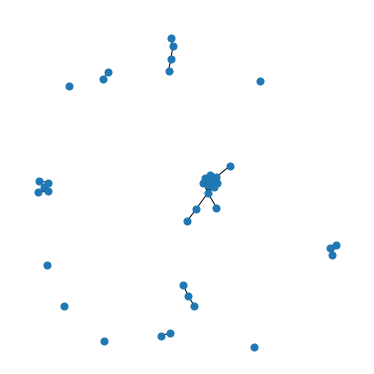

In [ ]:
print('Количество вершин:', G.number_of_nodes())
print('Количество ребёр:', G.number_of_edges())
plt.figure(figsize=(7, 7))
nx.draw(G, node_size = 20)
plt.show()

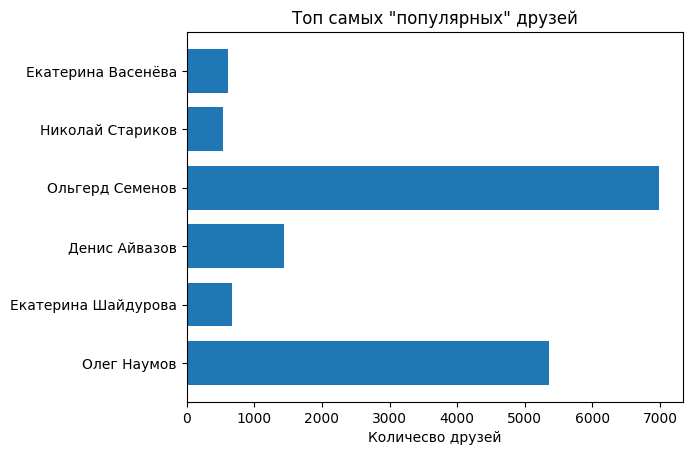

In [ ]:
names = []
nums = []
for node in G.nodes:
  if G.nodes[node]['tot_friends'] < 500:
    continue
  names.append(G.nodes[node]['name'])
  nums.append(G.nodes[node]['tot_friends'])

fig, ax = plt.subplots()
y_pos = range(0, 200*len(names), 200)
w = [150 for i in range(len(names))]
ax.barh(y_pos, nums, align='center', height=w)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.set_xlabel('Количесво друзей')
ax.set_title('Топ самых "популярных" друзей')

plt.show()


Как видим, с поддержанием актуальных социальных связей в вк у меня все плохо. Поэтому расширим граф, добавив туда информацию о друзьях друзей. Однако, если добавить всех друзе второго порядка, то в графе получится 16тыс вершин, т.к. среди моих друзей есть очень широко известные в узких кругах люди в количеством друзей >500. Опытным путем было установлено, что добавление 70 друзей от каждого друга в целом позволяет сохранить смысловую структуру графа.

In [ ]:
#добавляем друзей друзей аналогично тому, как это делалось ранее
nodes = list(G.nodes()).copy()
for node in progressbar.progressbar(nodes):
  try:
    his_friends = api.friends.get(user_id=node, fields = 'sex,city,universities', count = 70)['items']
    his_friends = [profile for profile in his_friends if not(profile.get('deactivated'))]
  except:
    #в случае, если профиль приватный, получить информацию о друзьях не получится
    continue
  for profile in his_friends:
    if not(profile.get('city')): pr_city = 'unknown'
    else: pr_city = profile['city']['title']
    G.add_node(profile['id'], sex = profile['sex'], city = pr_city, 
               name = profile['first_name']+' '+profile['last_name')
  time.sleep(0.1)  #иначе ругается, что слишком много запросов в секунду

100% (38 of 38) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


In [ ]:
#добавляем связи между ними
for node in progressbar.progressbar(G.nodes):
  try:
    his_friends = api.friends.get(user_id=node)['items']
  except:
    continue
  common = [id for id in his_friends if id in G.nodes()]
  for x in common:
    G.add_edge(node, x)
  time.sleep(0.3)  #иначе ругается, что слишком много запросов в секунду

100% (1825 of 1825) |####################| Elapsed Time: 0:06:05 Time:  0:06:05


In [ ]:
#на всякий случай сохраним граф!
nx.write_gexf(G, 'u70friends_graph.gexf')

In [ ]:
print('Количество вершин:', G.number_of_nodes())
print('Количество ребёр:', G.number_of_edges())

Количество вершин: 1611
Количество ребёр: 5922


### Упрощение графа
На текущий момент, в графе $1611$ вершин и $5922$ ребра. Проанализировав зависимость числа вершин $n$ степени $k$ от $k$ можно заметить, что степень более чем половины вершин не превосходит $10$. 

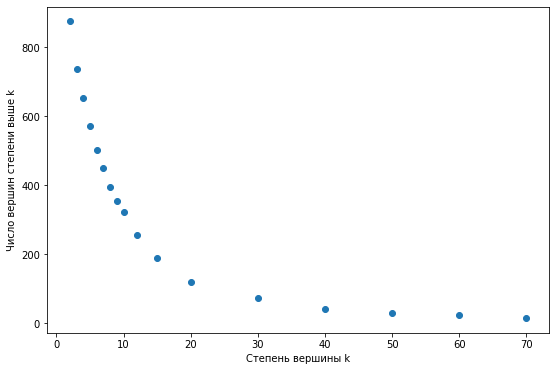

In [ ]:
x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50, 60, 70]
y = []
for i in x:
  y.append(sum([1 for node, deg in G.degree() if deg > i]))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.xlabel('Степень вершины k')
plt.ylabel('Число вершин степени выше k')
plt.show()

Удалим из графа вершины степени $k < 7$, чтобы понизить размерность графа

In [ ]:
my_fri_ids = list(G[144875139])
to_del = []
for node, deg in G.degree():
  if deg < 7 and not(node in my_fri_ids):
    to_del.append(node)
G.remove_nodes_from(to_del)

In [ ]:
print('Количество вершин:', G.number_of_nodes())
print('Количество ребёр:', G.number_of_edges())

Количество вершин: 508
Количество ребёр: 3704


Попробуем посмотреть, что у нас получилось. Для этого, напишем красивый метод отрисовки графа с помощью библиотеки Plotly

In [ ]:
#Один раз посчитаем векторное представление вершин графа, чтобы в дальнейшем не тратить на это время
layout = nx.spring_layout(G)

In [ ]:
#сохраним представление на всякий случай
file = open('layout.txt', 'w')
for node, coord in layout.items():
  file.write(str(node)+' '+str(coord[0])+' '+str(coord[1])+'\n')
file.close()


In [ ]:
edge_x = []
edge_y = []
for edge in G.edges():
  id1 = edge[0]
  id2 = edge[1]
  x0, y0 = layout[id1]
  x1, y1 = layout[id2]
  edge_x.append(x0)
  edge_x.append(x1)
  edge_x.append(None)
  edge_y.append(y0)
  edge_y.append(y1)
  edge_y.append(None)

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'),
                        hoverinfo='none', mode='lines')

node_x = []
node_y = []
for node in G.nodes():
  x, y = layout[node]
  node_x.append(x)
  node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
                        marker=dict(showscale=True, colorscale='Rainbow',
                                    reversescale=True, color=[],size=10,
                                    colorbar=dict(thickness=15, title='Степень вершины',
                                                  xanchor='left', titleside='right'),
                                    line_width=2))

#Раскрашиваем вершины в соответсвии с их степенью
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))

    name = G.nodes()[adjacencies[0]]['name']
    node_text.append('Degree: '+str(len(adjacencies[1]))+'<br>'+name)

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig_layout = go.Layout(title='<br>',
                       titlefont_size=16,
                       showlegend=False,
                       hovermode='closest',
                       margin=dict(b=10,l=5,r=10,t=40),
                       width=900, height=600,
                       xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                       yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace], layout=fig_layout)
fig.show()


### Анализ графа
Теперь, когда граф наконец-то готов, можно посчитать основные статистики



In [ ]:
print('Size:', G.number_of_nodes())
print('Order:', G.number_of_edges())
print('Diameter:',nx.diameter(G))
print('Radius:', nx.radius(G))
print('Average clustering coefficient:',  round(nx.average_clustering(G), 4))
print('Average path lenght:', round(nx.average_shortest_path_length(G),4))

Size: 508
Order: 3704
Diameter: 4
Radius: 2
Average clustering coefficient: 0.6
Average path lenght: 3.3831


In [ ]:
sex = {1: 0, 2: 0}
for node in G.nodes:
  sex[G.nodes[node]['sex']] += 1

print('Women:', round(sex[1]/G.number_of_nodes()*100), "%")
print('Men:', round(sex[2]/G.number_of_nodes()*100), "%")

Women: 45 %
Men: 55 %


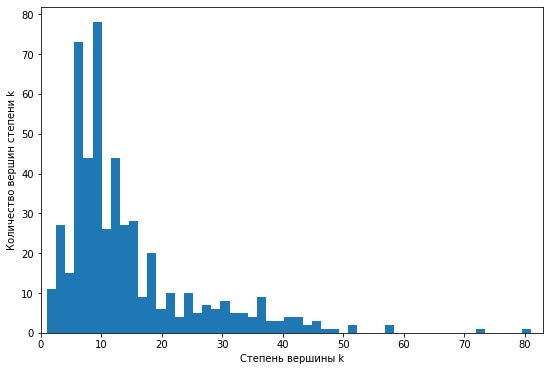

In [ ]:
degree = dict(G.degree())
num_bins = len(set(degree.values()))
plt.figure(figsize=(9, 6))
plt.hist(degree.values(), num_bins)
plt.xlim(0, 83)
plt.xlabel('Степень вершины k')
plt.ylabel('Количество вершин степени k')
plt.show()

Параметры диаметра и радиуса совершенно ожидаемы, учитывая построение графа. Распределение степеней вершин соответсвует power law. Посмотрим, какая из классических моделей построения случайного графа окажется ближе к заданному графу?

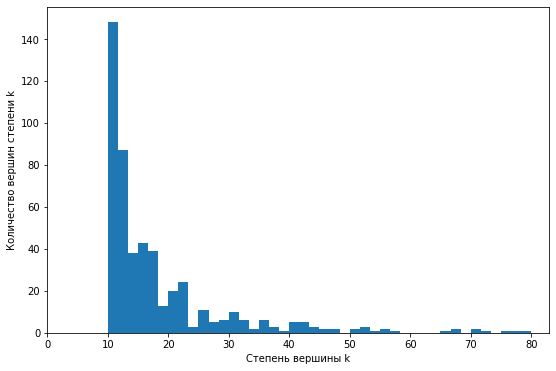

In [ ]:
R = nx.barabasi_albert_graph(508, 10)
degree = dict(R.degree())
num_bins = len(set(degree.values()))
plt.figure(figsize=(9, 6))
plt.hist(degree.values(), num_bins)
plt.xlim(0, 83)
plt.xlabel('Степень вершины k')
plt.ylabel('Количество вершин степени k')
plt.show()

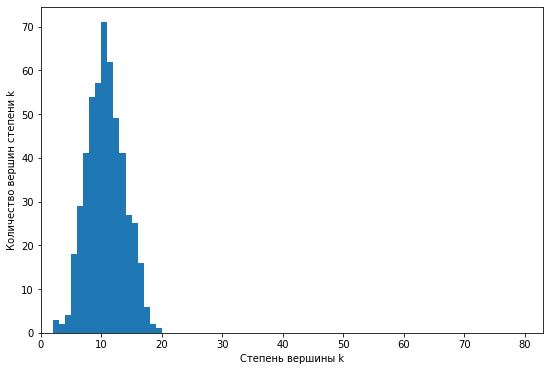

In [ ]:
R = nx.erdos_renyi_graph(508, 0.02)
degree = dict(R.degree())
num_bins = len(set(degree.values()))
plt.figure(figsize=(9, 6))
plt.hist(degree.values(), num_bins)
plt.xlim(0, 83)
plt.xlabel('Степень вершины k')
plt.ylabel('Количество вершин степени k')
plt.show()

Модель Эрдёша-Реньи лучше моделирует тяжелый левых хвост распределение, однако совсем не справляется с моделированием вершин высокой степени. Модель Барабаши-Альберта справляется значительно лучше, за исключением того момента, что в ней совсем не присутсвуют вершины степени меньше 10.

### Центральности
Рассмотрим какие значения принимают на полученном графе основные центральности: degree centrality, closeness centrality, betweenness centrality. Отметим на графе точки с максимальными значениями центральностей

In [ ]:
degr = sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:15]
closs = sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:10]
betw = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
print('Degree centrality')
for node, val in degr:
  print(G.nodes[node]['name'], round(val, 4))

Degree centrality
Екатерина Шайдурова 0.1598
Денис Айвазов 0.142
Александр Гришутин 0.1124
Максим Абрамов 0.1124
Руслан Еникеев 0.1026
Наталья Лунева 0.1006
Иван Эрлих 0.0966
Никита Семёнов 0.0927
Александр Ненашев 0.0907
Евгений Молчанов 0.0907
Владимир Гуровиц 0.0888
Маргарита Автандилова 0.0868
Андрей Власов 0.0868
Михаил Голофаев 0.0848
Виталий Павленко 0.0848


In [ ]:
#Подстветим эти точки на графе
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
                        marker=dict(color='white', size=10, line_width=2))

N = G.number_of_nodes()
min_degr = degr[-1][1]
deg_mask = [0 if val < min_degr else int(val*100) for _, val in nx.degree_centrality(G).items()]

big_x = [node_x[i] for i in range(N) if (deg_mask[i] != 0)]
big_y = [node_y[i] for i in range(N) if (deg_mask[i] != 0)]
deg_mask = [x for x in deg_mask if x]

big_trase = go.Scatter(x=big_x, y=big_y, mode='markers', hoverinfo='text',
                       marker=dict(color='red', size=deg_mask, line_width=2, line_color = 'black'))

fig1 = go.Figure(data=[edge_trace, node_trace, big_trase],
                 layout=fig_layout)
fig1.update_layout(title='Top-15 nodes with degree centrality')
fig1.show()

In [ ]:
min_degr = closs[-1][1]
deg_mask = [0 if val < min_degr else int(val*50) for _, val in nx.closeness_centrality(G).items()]
big_x = [node_x[i] for i in range(N) if (deg_mask[i] != 0)]
big_y = [node_y[i] for i in range(N) if (deg_mask[i] != 0)]
deg_mask = [x for x in deg_mask if x]
big_trase = go.Scatter(x=big_x, y=big_y, mode='markers', hoverinfo='text',
                       marker=dict(color='red', size=deg_mask, line_width=2, line_color = 'black'))

fig2 = go.Figure(data=[edge_trace, node_trace, big_trase],
                 layout=fig_layout)
fig2.update_layout(title='Top-10 nodes with closeness centrality')
fig2.show()

In [ ]:
print('Closenes centrality')
for node, val in closs:
  print(G.nodes[node]['name'], round(val, 4))

Degree centrality
Анастасия Валеева 0.5195
Денис Айвазов 0.4159
Екатерина Шайдурова 0.4139
Наталья Лунева 0.4005
Максим Регенов 0.3949
Владислав Рыхлов 0.3912
Айрат Валиев 0.3876
Александра Штепен 0.3856
Евгения Бобренкова 0.3798
Михаил Голофаев 0.3798


In [ ]:
min_degr = betw[-1][1]
deg_mask = [0 if val < min_degr else int(val*100+5) for _, val in nx.betweenness_centrality(G).items()]
big_x = [node_x[i] for i in range(N) if (deg_mask[i] != 0)]
big_y = [node_y[i] for i in range(N) if (deg_mask[i] != 0)]
deg_mask = [x for x in deg_mask if x]
big_trase = go.Scatter(x=big_x, y=big_y, mode='markers', hoverinfo='text',
                       marker=dict(color='red', size=deg_mask, line_width=2, line_color = 'black'))

fig3 = go.Figure(data=[edge_trace, node_trace, big_trase],
                 layout=fig_layout)
fig3.update_layout(title='Top-10 nodes with betweenness centrality')
fig3.show()

In [ ]:
print('Betweenness centrality')
for node, val in betw:
  print(G.nodes[node]['name'], round(val, 4))

Betweenness centrality
Анастасия Валеева 0.5486
Маргарита Автандилова 0.1249
Екатерина Шайдурова 0.1162
Татьяна Сорокина 0.1022
Каролина Акохова 0.0862
Михаил Голофаев 0.0858
Руслан Еникеев 0.0795
Денис Айвазов 0.0795
Дарья Серегина 0.0681
Дмитрий Черников 0.0592


### Обнаружение сообществ

In [ ]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

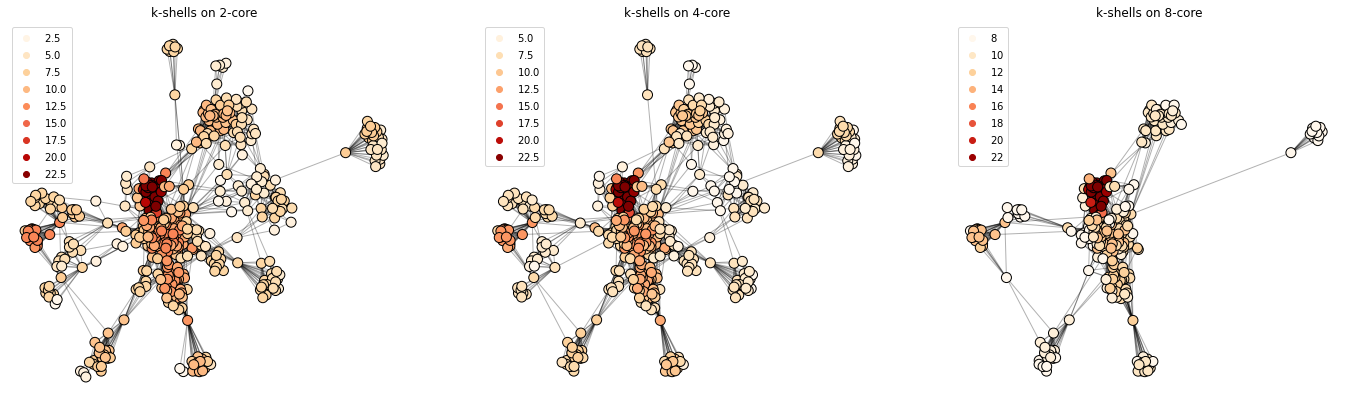

In [ ]:
plt.figure(figsize=(24, 7))

x_max, y_max = np.array(list(layout.values())).max(axis=0)
x_min, y_min = np.array(list(layout.values())).min(axis=0)

j = 1
for i in [2, 4, 8]:
    plt.subplot(1, 3, j)
    subG = nx.k_core(G, i)
    j += 1
    nodes = nx.draw_networkx_nodes(subG, layout, cmap=plt.cm.OrRd,
                                   node_color=k_core_decompose(subG), node_size=100, 
                                   edgecolors='black')
    nx.draw_networkx_edges(subG, layout, alpha=0.3, width=1, edge_color='black')
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i))

In [ ]:
def largest_cliques(G):
    cmap = plt.cm.rainbow
    cliques = [i for i in nx.find_cliques(G)]
    max_size = len(max(cliques, key=len))
    colors = []
    widths = []
    i = 0
    for c in cliques:
        if len(c) == max_size:
            c_colors = []
            for node in G.nodes:
                c_colors.append(cmap(i*0.5)[:3] if node in c else (1, 1, 1))
            i += 1
            colors.append(c_colors)
            c_width = []
            for e in G.edges:
                c_width.append(1.01 if set(e).issubset(c) else 1)
            widths.append(c_width)
    return np.array(colors), np.array(widths)

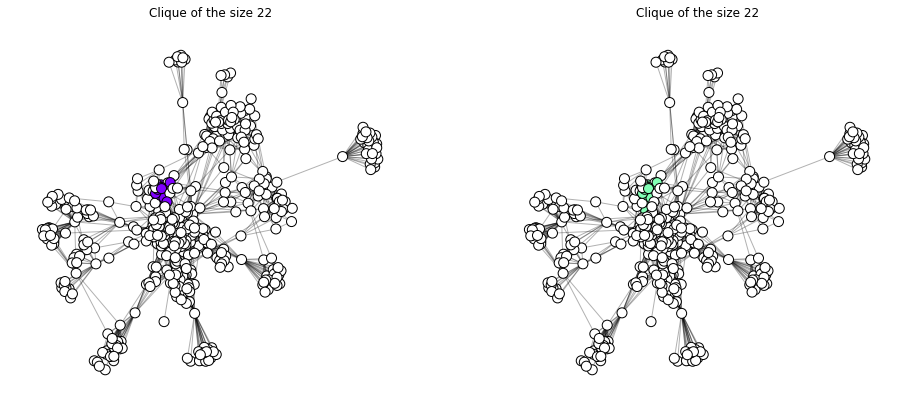

In [ ]:
colors, widths = largest_cliques(G)
size = np.unique(colors[0], axis=0, return_counts=True)[1][0]

plt.figure(figsize=(16, 7))
for i in range(colors.shape[0]):
    b_edges = np.array(list(G.edges))[widths[i] == widths[i].max()]
    plt.subplot(1, 2, i+1)
    
    nx.draw_networkx_edges(G, layout, alpha=0.3, width=widths[i].min())
    nx.draw_networkx_edges(G, layout, width=widths[i].max(), edgelist=b_edges)
    nodes = nx.draw_networkx_nodes(G, layout, node_color=colors[i], node_size=100, 
                                   linewidths=1, edgecolors='black')
    plt.title('Clique of the size {}'.format(size))
    plt.axis('off')

In [ ]:
def edge_betweenness(G, n):
    com_gen = nx.algorithms.community.girvan_newman(G)
    labels = []
    for i in range(n):
        communities = next(com_gen)
        c_com = []
        for node in G.nodes:
            for i, c in enumerate(communities):
                if node in c:
                    c_com.append(i)
        labels.append(c_com)
    return np.array(labels)

In [ ]:
labels = edge_betweenness(G, 12)

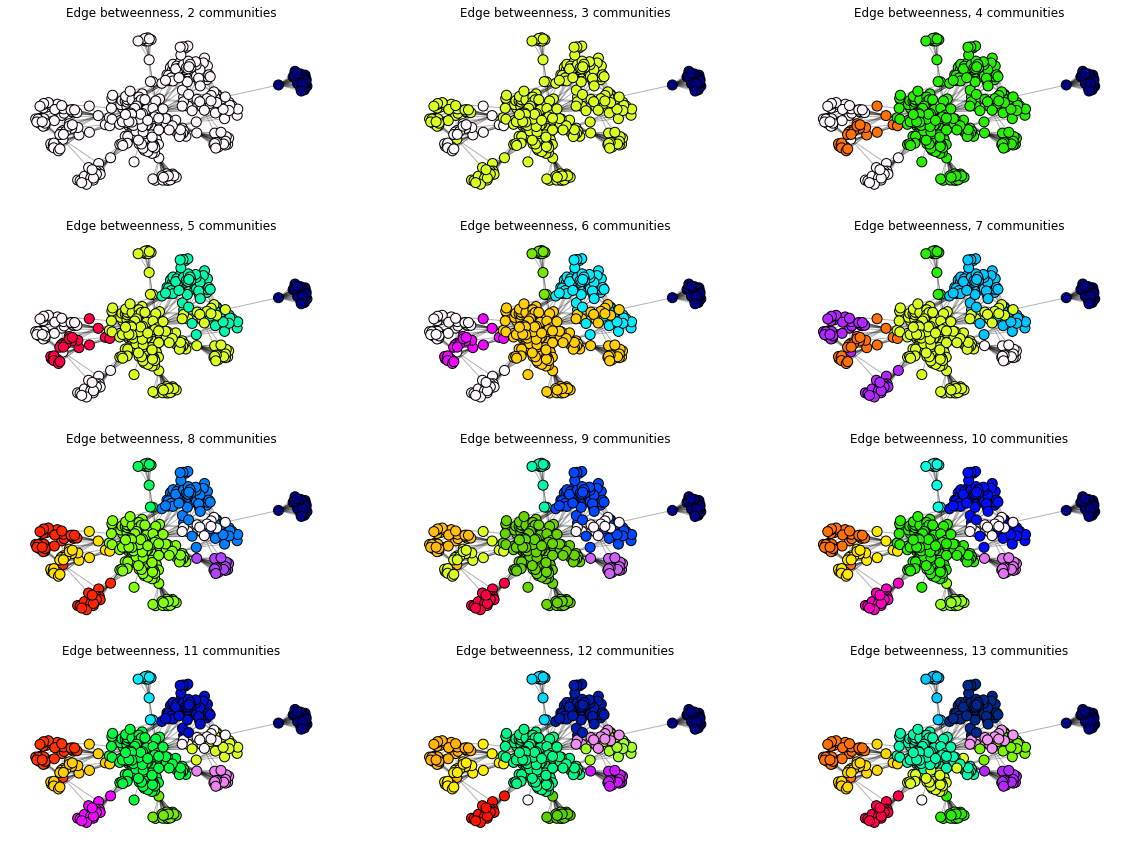

In [ ]:
plt.figure(figsize=(5*4, 5*3))
for i in range(labels.shape[0]):
    plt.subplot(4, 3, i+1)
    nx.draw_networkx_nodes(G, layout, cmap=plt.cm.gist_ncar, node_color=labels[i], 
                           node_size=100, edgecolors='black')
    nx.draw_networkx_edges(G, layout, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

In [ ]:
def edge_betw_modularity(G, n):
    labels = edge_betweenness(G, n)
    m = len(G.nodes)
    nodes = list(G.nodes())
    modularity = []
    for labs in labels:
      comms = {}
      for i in range(m):
        if labs[i] in comms.keys():
          comms[labs[i]].add(nodes[i])
        else:
          comms[labs[i]] = {nodes[i]}
      modularity.append(nx.algorithms.community.modularity(G, comms.values()))
    return np.array(modularity)

In [ ]:
n_iterations = 20
modularity = edge_betw_modularity(G, n_iterations)

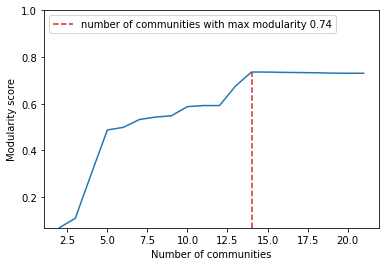

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((modularity.min(), 1))
plt.show()

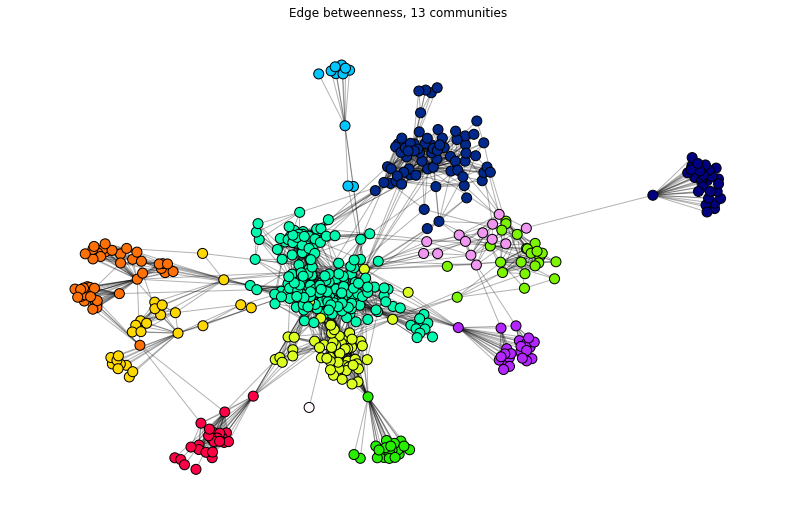

In [ ]:
plt.figure(figsize=(14, 9))
nx.draw_networkx_nodes(G, layout, cmap=plt.cm.gist_ncar, node_color=labels[-1], 
                       node_size=100, edgecolors='black')
nx.draw_networkx_edges(G, layout, alpha=0.3)
plt.title('Edge betweenness, 13 communities')
plt.axis('off')
plt.show()